采用PyTorch搭建卷积神经网络(CNN)并进行以下孤立词的简单语音识别：
1. 打开后备箱
2. 关闭后备箱
3. 开后备箱
4. 关后备箱
@Vela 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%matplotlib inline

导入PyTorch相关的库

In [3]:
!pip install torchaudio
!pip install pydub
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


导入数据库

In [5]:
import os
from typing import Tuple, Optional, Union
from pathlib import Path

from torchaudio import load as AudioLoad
from torch.utils.data import Dataset
from torch import Tensor


FOLDER_IN_ARCHIVE = "MyDataset"
EXCEPT_FOLDER = "_background_noise_"

# 加载列表
def _load_list(root, *filenames):
    output = []
    for filename in filenames:
        filepath = os.path.join(root, filename)
        with open(filepath) as fileobj:
            output += [os.path.normpath(os.path.join(root, line.strip())) for line in fileobj]
    return output

# 加载语音
def load_item(filepath: str, path: str) -> Tuple[Tensor, int, str, str, int]:
    relpath = os.path.relpath(filepath, path)
    label, filename = os.path.split(relpath)
    # Load audio
    waveform, sample_rate = AudioLoad(filepath)
    return waveform, sample_rate, label

# 定义数据集类
class MyDataset(Dataset):

    # 初始化方法
    def __init__(self,
                 root: Union[str, Path],
                 folder_in_archive: str = FOLDER_IN_ARCHIVE,
                 subset: Optional[str] = None,
                 ) -> None:

        assert subset is None or subset in ["training", "validation", "testing"], (
            "When `subset` not None, it must take a value from "
            + "{'training', 'validation', 'testing'}."
        )

        root = os.fspath(root)

        self._path = os.path.join(root, folder_in_archive)


        if subset == "validation":
            self._walker = _load_list(self._path, "validation_list.txt")
        elif subset == "testing":
            self._walker = _load_list(self._path, "testing_list.txt")
        elif subset == "training":
            excludes = set(_load_list(self._path, "validation_list.txt", "testing_list.txt"))
            walker = sorted(str(p) for p in Path(self._path).glob('*/*.wav'))
            self._walker = [
                w for w in walker
                if EXCEPT_FOLDER not in w
                and os.path.normpath(w) not in excludes
            ]
        else:
            walker = sorted(str(p) for p in Path(self._path).glob('*/*.wav'))
            self._walker = [w for w in walker if EXCEPT_FOLDER not in w]

    # 定义得到样本方法
    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, str, int]:
        fileid = self._walker[n]
        return load_item(fileid, self._path)


    def __len__(self) -> int:
        return len(self._walker)


建立数据集子集，包括训练集、测试集与有效集

In [6]:
import os


class SubsetSC(MyDataset):
    def __init__(self, subset: str = None):
        super().__init__("./drive/MyDrive")

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath, encoding='utf8') as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label = train_set[0]

展示一个来自训练集的音频信息

波形长度 torch.Size([1, 24080])
波形采样率 8000


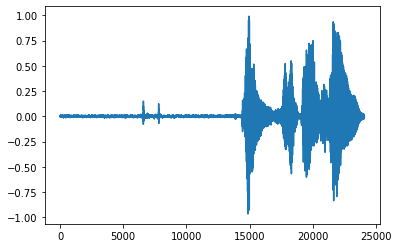

In [7]:
print("波形长度 {}".format(waveform.size()))
print("波形采样率 {}".format(sample_rate))

plt.plot(waveform.t().numpy())

列出音频标签

In [8]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['关后备箱', '关闭后备箱', '开后备箱', '打开后备箱']

列举几个声音样本
这个是“打开后备箱”

In [9]:
waveform_first, sample_first, label_first = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_first)


这个是“关后备箱”

In [10]:
waveform_last, sample_last, label_last = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_last)

对音频信号重采样（统一采样率）
由于大家设备不同，导致录制的音频也不同。
同时，8000Hz完全可以胜任语音采样。
这里听一下重采样后的信号

tensor([[-2.9907e-05, -6.2506e-07, -6.0502e-05,  ..., -9.0837e-05,
         -9.1697e-05, -3.7553e-07]])


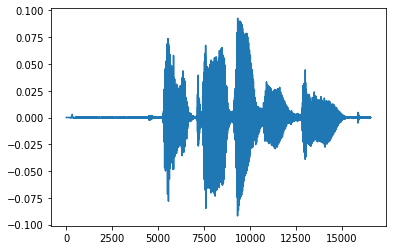

In [11]:
new_sample_rate = 8000
transform = nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate),
    torchaudio.transforms.Vad(sample_rate = sample_rate)
)
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform_last)
print(transformed)
plt.plot(transformed.t().numpy())
ipd.Audio(transformed.numpy(), rate=8000)
#import librosa.display
#librosa.display.specshow(librosa.power_to_db(transformed.numpy(), ref = np.max), y_axis='mel', fmax=8000, x_axis='time')


使用音频文件的索引来对应其标签

In [12]:
def label_to_index(word):
    # 返回标签对应的数据集索引
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # 返回数据集索引对应的标签
    return labels[index]


word_start = "打开后备箱"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

打开后备箱 --> tensor(3) --> 打开后备箱


将信号转换成张量，适应CNN模型的输入

In [13]:
def pad_sequence(batch):
    # 用填充0的方法让所有张量等维
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # 将数据处理成几个张量的形式并合并成一个批张量( batch tensor )

    tensors, targets = [], []

    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # 将几个张量转换成批张量（张量集合，也是一个张量）
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

神经网络定义
第一层为80点卷积层，在处理8000Hz音频时，帧长大约25ms。

In [14]:
class M5_CNN(nn.Module):
    def __init__(self, n_input=1, n_output=4, stride=4, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=200, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(4 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5_CNN(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("参数个数： %s" % n)

M5_CNN(
  (conv1): Conv1d(1, 32, kernel_size=(200,), stride=(4,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=4, bias=True)
)

参考论文 VERY DEEP CONVOLUTIONAL NEURAL NETWORKS FOR RAW WAVEFORMS ，给出优化器的结构，其中sceduler是为了在20次迭代以后降低学习率，提高泛化能力




In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

训练，测试网络
--------------------------------

训练：根据数据集进行学习

测试：测试训练集的正确率



In [16]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 展示训练状态
        if batch_idx % log_interval == 0:
            print(f"迭代次数: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\t训练损失: {loss.item():.6f}")

        # 更新状态栏
        pbar.update(pbar_update)
        # 记录训练损失
        losses.append(loss.item())

测试函数定义

In [17]:
def number_of_correct(pred, target):
    # 计算分类正确的选项
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # 找到最接近的索引
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # 所有数据的预处理方式应该均相同
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # 更新状态栏
        pbar.update(pbar_update)
        Accuracy.append(100. * correct / len(test_loader.dataset))

    print(f"\n迭代次数 {epoch}\t准确率: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

开始模型训练

迭代次数: 1 [0/254 (0%)]	训练损失: 1.401614

迭代次数 1	准确率: 13/48 (27%)

迭代次数: 2 [0/254 (0%)]	训练损失: 1.459235

迭代次数 2	准确率: 14/48 (29%)

迭代次数: 3 [0/254 (0%)]	训练损失: 1.383632

迭代次数 3	准确率: 15/48 (31%)

迭代次数: 4 [0/254 (0%)]	训练损失: 1.308672

迭代次数 4	准确率: 14/48 (29%)

迭代次数: 5 [0/254 (0%)]	训练损失: 1.247972

迭代次数 5	准确率: 12/48 (25%)

迭代次数: 6 [0/254 (0%)]	训练损失: 1.217723

迭代次数 6	准确率: 14/48 (29%)

迭代次数: 7 [0/254 (0%)]	训练损失: 1.178289

迭代次数 7	准确率: 16/48 (33%)

迭代次数: 8 [0/254 (0%)]	训练损失: 1.128365

迭代次数 8	准确率: 17/48 (35%)

迭代次数: 9 [0/254 (0%)]	训练损失: 1.078575

迭代次数 9	准确率: 18/48 (38%)

迭代次数: 10 [0/254 (0%)]	训练损失: 1.036963

迭代次数 10	准确率: 18/48 (38%)

迭代次数: 11 [0/254 (0%)]	训练损失: 0.989949

迭代次数 11	准确率: 16/48 (33%)

迭代次数: 12 [0/254 (0%)]	训练损失: 0.966340

迭代次数 12	准确率: 24/48 (50%)

迭代次数: 13 [0/254 (0%)]	训练损失: 0.948164

迭代次数 13	准确率: 23/48 (48%)

迭代次数: 14 [0/254 (0%)]	训练损失: 0.881979

迭代次数 14	准确率: 20/48 (42%)

迭代次数: 15 [0/254 (0%)]	训练损失: 0.827598

迭代次数 15	准确率: 18/48 (38%)

迭代次数: 16 [0/254 (0%)]	训练损失: 0.789148

迭代次数 16	准确率: 21/48 (

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22833 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_te

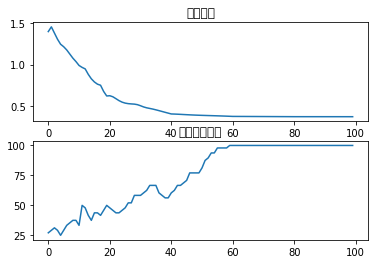

In [18]:
log_interval = 20
n_epoch = 100

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
Accuracy = []

# 所有数据的预处理方式应该均相同
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# 展示训练损失与准确率
plt.subplot(2,1,1)
plt.plot(losses);
plt.title("训练损失");
plt.subplot(2,1,2)
plt.plot(Accuracy);
plt.title("训练后准确率");

根据输入计算其分类

In [19]:
def predict(tensor):
    # 使用已经训练过的神经网络来预测
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]

print(f"期望: {utterance}. 预测结果: {predict(waveform)}.")
ipd.Audio(waveform.numpy(), rate=sample_rate)

期望: 打开后备箱. 预测结果: 打开后备箱.


以下是一个分类不成功的例子

In [20]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        print(f"数据 #{i}. 期望: {utterance}. 预测结果: {output}.")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        break
else:
    print("所有数据均完全正确！这并不应该出现，请检查数据集是否太小或训练集与测试集重复")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
ipd.Audio(waveform.numpy(), rate=sample_rate)

所有数据均完全正确！这并不应该出现，请检查数据集是否太小或训练集与测试集重复


录音并尝试

In [34]:
import sys
# js代码，录制3秒音频
def record(seconds = 3):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"录音开始，将持续 {seconds} 秒.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("录音结束")
    b = b64decode(s.split(",")[1])

    # 录音格式定义
    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


waveform, sample_rate = record()
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
waveform_t = transform(waveform)
print(f"预测结果： {predict(waveform)}.")

ipd.Audio(waveform_t.numpy(), rate = new_sample_rate)

录音开始，将持续 3 秒.


<IPython.core.display.Javascript object>

录音结束
预测结果： 关后备箱.


可以看出，搭建的神经网络准确率高，且具有不让人失望的泛化能力




In [30]:
file = "./drive/MyDrive/校验文件/" + "开后备箱0.wav"
waveform, sample_rate = torchaudio.load(file)
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
waveform_t = transform(waveform)
print(f"预测结果： {predict(waveform)}.")

ipd.Audio(waveform_t.numpy(), rate = new_sample_rate)

预测结果： 开后备箱.
